In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib




# Example: Post-synaptic EEG-response of a single synapse #
This is an example of **``LFPy``** running in an **``IPython notebook``**. To run through this example code and produce output, press **``<shift-Enter>``** in each code block below.

First step is to **import ``LFPy``** and other packages for analysis and plotting:

In [2]:
import numpy as np
import LFPy

Then, create the cell object using the **LFPy.Cell**
-class, specifying the morphology file.


In [3]:
cell_params = {'morphology': 'morphologies/L5_Mainen96_LFPy.hoc',
               'cm' : 1.0,                 # membrane capacitance
               'Ra' : 150,                 # axial resistance
               'tstart': 0.,
               'passive' : True,           # switch on passive mechs
               'nsegs_method' : 'lambda_f',# method for setting number of segments,
               'lambda_f' : 100,           # segments are isopotential at this frequency
               'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -70}, # passive params
               'tstop': 40
               }
cell = LFPy.Cell(**cell_params)

One can now use **LFPy.Synapse**-class to insert a single 
synapse onto the cell model, and set the spike time(s) using **LFPy.Synapse.set_spike_times()**:

In [4]:
synapse_params = {'idx': cell.get_closest_idx(x=0, y=0, z=1000),  # Find index for synaptic (soma at origo for now)
                  'e': 0.,  # reversal potential
                  'syntype': 'ExpSyn',  # exponential synapse
                  'tau': 5.,  # synapse time constant
                  'weight': 0.001,  # 0.001, # synapse weight
                  'record_current': True  # record synapse current
                 }
synapse = LFPy.Synapse(cell, **synapse_params)
synapse.set_spike_times(np.array([5.]))


We now have what we need to calculate the current dipole moment,
using a built in method **LFPy.Cell.simulate()** method to run the simulation.

In [5]:
cell.simulate(rec_current_dipole_moment=True)

First we define some plotting functions

In [6]:
def plot_cell_to_ax(cell, ax, synidxs):
    """ Function to plot cell morphology to axis """
    for idx in range(cell.totnsegs):
        if idx == 0:
            ax.plot(cell.xmid[idx], cell.zmid[idx], 'ko')
        else:
            ax.plot([cell.xstart[idx], cell.xend[idx]],
                    [cell.zstart[idx], cell.zend[idx]], c='k')

    for synidx in synidxs:
        l, = ax.plot(cell.xmid[synidx], cell.zmid[synidx], '*',
                c="r", ms=10)
    ax.legend([l], ["Synapse"], frameon=False, bbox_to_anchor=[1, -0.1])

def plot_EEG_sphere(fig, eeg, x_eeg, y_eeg, z_eeg):
    """ Function to plot the 3D four-sphere head model with EEG """
    from mpl_toolkits.mplot3d import Axes3D
    ax = fig.add_subplot(322, projection='3d',
                         title="Max EEG potential\nat 4-sphere surface")
    vmax = 6
    vmin = -vmax
    clr = lambda phi: plt.cm.PRGn((phi - vmin) / (vmax - vmin))
    clrs = clr(eeg)
    surf = ax.plot_surface(x_eeg.reshape(num_theta, num_phi),
                           y_eeg.reshape(num_theta, num_phi),
                           z_eeg.reshape(num_theta, num_phi),
                           rstride=1, cstride=1, facecolors=clrs,
                           linewidth=0, antialiased=False)

    #ax.set_aspect('equal')
    ax.axis('off')
    ax.set_xlim3d(-65000, 65000)
    ax.set_ylim3d(-65000, 65000)
    ax.set_zlim3d(-65000, 65000)
    ax.view_init(10, 0)

    # colorbar
    cax = fig.add_axes([0.65, 0.75, 0.25, 0.01])
    m = plt.cm.ScalarMappable(cmap=plt.cm.PRGn)
    ticks = np.linspace(vmin, vmax, 5) # global normalization
    m.set_array(ticks)
    cbar = plt.colorbar(m, cax=cax,
                        extend='both', orientation='horizontal')
    cbar.outline.set_visible(False)
    cbar.set_ticks(ticks)
    cbar.set_label(r'$\phi$ (pV)', labelpad=1.)


We then define the EEG coordinates, and calculate the EEG signals

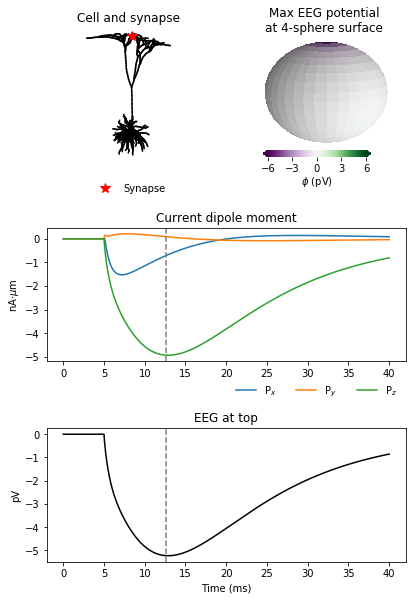

In [7]:
P = cell.current_dipole_moment

# four_sphere properties
radii = [79000., 80000., 85000., 90000.]  # Radius of the different spheres in um (brain, CSF, skull, scalp)
sigmas = [0.3, 1.5, 0.015, 0.3]  # Conductivity within the different regions (S/m)
rad_tol = 1e-2
somapos = np.array([0., 0., 77500])

# Find mid point between synaptic input and soma to position single-cell current dipole
r_soma_syns = [cell.get_intersegment_vector(idx0=0, idx1=i) for i in cell.synidx]
r_mid = np.average(r_soma_syns, axis=0)
r_mid = somapos + r_mid/2.

# Find time trace of EEG signal at the top of the head
eeg_coords_top = np.array([[0., 0., radii[3] - rad_tol]])
four_sphere_top = LFPy.FourSphereVolumeConductor(radii, sigmas, eeg_coords_top)
pot_db_4s_top = four_sphere_top.calc_potential(P, r_mid)
eeg_top = np.array(pot_db_4s_top) * 1e9  # Convert to pV

# measurement points at head surface for single time-step
# for nice plot use theta_step = 1 and phi_step = 1. NB: Long computation time.
theta_step = 10
phi_step = 10
theta, phi_angle = np.mgrid[0.:180.:theta_step, 0.:360.+phi_step:phi_step]

num_theta = theta.shape[0]
num_phi = theta.shape[1]
theta = theta.flatten()
phi_angle = phi_angle.flatten()

theta_r = np.deg2rad(theta)
phi_angle_r = np.deg2rad(phi_angle)

x_eeg = (radii[3] - rad_tol) * np.sin(theta_r) * np.cos(phi_angle_r)
y_eeg = (radii[3] - rad_tol) * np.sin(theta_r) * np.sin(phi_angle_r)
z_eeg = (radii[3] - rad_tol) * np.cos(theta_r)
eeg_coords = np.vstack((x_eeg, y_eeg, z_eeg)).T

# potential in 4S with db
time_max = np.argmax(np.linalg.norm(P, axis=1))
p = P[time_max, None]

four_sphere = LFPy.FourSphereVolumeConductor(radii, sigmas, eeg_coords)

pot_db_4s = four_sphere.calc_potential(p, r_mid)
eeg = pot_db_4s.reshape(num_theta, num_phi)*1e9# from mV to pV

P_mag = np.sqrt(P[:, 0]**2 + P[:, 1]**2 + P[:, 2]**2)

plt.close('all')
fig = plt.figure(figsize=[6, 9])
fig.subplots_adjust(left=0.15, hspace=0.5, right=0.98, top=0.95)

morph_ax = fig.add_subplot(321, aspect=1, frameon=False,
                           title="Cell and synapse",
                           xticks=[], yticks=[])
plot_cell_to_ax(cell, morph_ax, cell.synidx)

plot_EEG_sphere(fig, eeg, x_eeg, y_eeg, z_eeg)

ax_p = fig.add_subplot(312, title="Current dipole moment", ylabel="nA$\cdot\mu$m")
ax_p.plot(cell.tvec, P[:, 0], label="P$_x$")
ax_p.plot(cell.tvec, P[:, 1], label="P$_y$")
ax_p.plot(cell.tvec, P[:, 2], label="P$_z$")
ax_p.axvline(cell.tvec[time_max], c='gray', ls='--')
ax_p.legend(frameon=False, ncol=4, bbox_to_anchor=[1, -0.1])

ax_eeg = fig.add_subplot(313, title="EEG at top", xlabel="Time (ms)",
                         ylabel='pV')
ax_eeg.plot(cell.tvec, eeg_top[0, :], 'k')

ax_eeg.axvline(cell.tvec[time_max], c='gray', ls='--')


plt.show()
# plt.savefig('example_EEG.pdf')